In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

from textblob import TextBlob

from utils import stop_words, make_corpus_df, get_data_between_dates, get_data_by_year, get_data_by_channel, make_list_of_processed_snippets, NETWORKS

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## We start the sentiment and subjectivity analysis on the entire dataset by analyzing differences between the networks.

Using the TextBlob NLP python package, we use a pre-trained Naive Bayes Classifiers which provides a score on our snippets between $[-1, 1]$ for sentiment (negative < 0, neutral = 0, positive > 0) and $[0, 1]$ for subjectivity, respectively. 

Using the sentiment scores from the sentiment classifier, we classify the snippet as being negative if the score < -0.25, neutral if 0.25 >= score >= -0.25, and finally as positive if score > 0.25. To reduce the amount of signals of weak polarity, we extend the boundaries for neutral sentiment from $[0, 0]$ to $[-0.25, 0.25]$, which increases the amount of neutral snippets and reduces both positive and negative snippets to only those with strong polarity, which is what we're utimately interested in analyzing.

Similarly, using the subjectivity scores from the subjectivity classifier, we classify a snippet as objective if the score < 0.5 and subjective if the score >= 0.5.

In [2]:
def polarity_classification(sentiment_score):
    if sentiment_score > 0.25:
        return 'positive'
    elif -0.25 <= sentiment_score <= 0.25:
        return 'neutral'
    else:
        return 'negative'

def subjectivity_classificiation(subjectivity_score):
    if subjectivity_score >= 0.5:
        return 'subjective'
    else:
        return 'objective'

def create_document(list_of_processed_snippets):
    return ' '.join(list_of_processed_snippets)

In [3]:
PARENT = 'TelevisionNewsV2'

In [4]:
corpus_df = make_corpus_df(PARENT)

In [55]:
_2019_data = get_data_by_year(corpus_df, 2019)
_2020_data = get_data_by_year(corpus_df, 2020)
final_years_df = pd.concat([_2019_data, _2020_data])
years = [str(i) for i in range(2009, 2019)]
years.append("\'19 + \'20")

In [5]:
corpus_df = corpus_df[['DateTime', 'Station', 'Show', 'IAShowID', 'Snippet']]
corpus_df['Snippet'] = make_list_of_processed_snippets(corpus_df, stop_words)

In [6]:
corpus_df['polarity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).polarity, axis=1)
corpus_df['subjectivity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).subjectivity, axis=1)
corpus_df['sentiment_class'] = corpus_df.apply(lambda row: polarity_classification(row['polarity']), axis=1)
corpus_df['subjectivity_class'] = corpus_df.apply(lambda row: subjectivity_classificiation(row['subjectivity']), axis=1)

In [8]:
cnn_df, fox_df, msnbc_df = get_data_by_channel(corpus_df, 'CNN'), get_data_by_channel(corpus_df, 'FOXNEWS'), get_data_by_channel(corpus_df, 'MSNBC')

In [9]:
cnn_sentiment_counts = cnn_df['sentiment_class'].value_counts()
fox_sentiment_counts = fox_df['sentiment_class'].value_counts()
msnbc_sentiment_counts = msnbc_df['sentiment_class'].value_counts()

cnn_subjectivity_counts = cnn_df['subjectivity_class'].value_counts()
fox_subjectivity_counts = fox_df['subjectivity_class'].value_counts()
msnbc_subjectivity_counts = msnbc_df['subjectivity_class'].value_counts()

In [10]:
stations = ['CNN', 'Fox News', 'MSNBC']

list_sentiment_counts = [cnn_sentiment_counts, fox_sentiment_counts, msnbc_sentiment_counts]
positive_counts = [i['positive'] for i in list_sentiment_counts]
neutral_counts = [i['neutral'] for i in list_sentiment_counts]
negative_counts = [i['negative'] for i in list_sentiment_counts]

list_subjectivity_counts = [cnn_subjectivity_counts, fox_subjectivity_counts, msnbc_subjectivity_counts]
objective_counts = [i['objective'] for i in list_subjectivity_counts]
subjective_counts = [i['subjective'] for i in list_subjectivity_counts]

In [11]:
cnn_pos_neg_ratio = cnn_sentiment_counts['positive'] / cnn_sentiment_counts['negative']
print('CNN Positive / Negative Ratio: ', cnn_pos_neg_ratio)
fox_pos_neg_ratio = fox_sentiment_counts['positive'] / fox_sentiment_counts['negative']
print('Fox Positive / Negative Ratio: ', fox_pos_neg_ratio)
msnbc_pos_neg_ratio = msnbc_sentiment_counts['positive'] / msnbc_sentiment_counts['negative']
print('MSNBC Positive / Negative Ratio: ', msnbc_pos_neg_ratio)

CNN Positive / Negative Ratio:  3.5822306238185253
Fox Positive / Negative Ratio:  2.4168797953964196
MSNBC Positive / Negative Ratio:  3.3430079155672825


In [12]:
cnn_obj_subj_ratio = cnn_subjectivity_counts['objective'] / cnn_subjectivity_counts['subjective']
print('CNN Obj / Subj Ratio: ', cnn_obj_subj_ratio)
fox_obj_subj_ratio = fox_subjectivity_counts['objective'] / fox_subjectivity_counts['subjective']
print('Fox Obj / Subj Ratio: ', fox_obj_subj_ratio)
msnbc_obj_subj_ratio = msnbc_subjectivity_counts['objective'] / msnbc_subjectivity_counts['subjective']
print('MSNBC Obj / Subj Ratio: ', msnbc_obj_subj_ratio)

CNN Obj / Subj Ratio:  1.3305565616322588
Fox Obj / Subj Ratio:  1.417515655668754
MSNBC Obj / Subj Ratio:  1.439900295420975


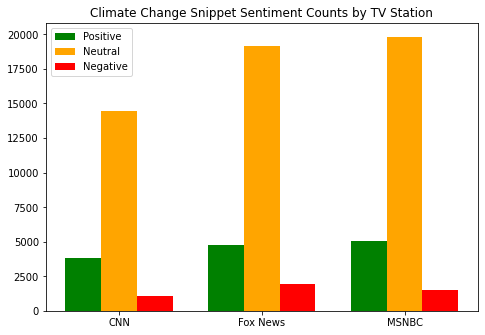

In [13]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, positive_counts, color='g', width=width, label="Positive")
ax.bar(X + 1*width, neutral_counts, color='orange', width=width, label="Neutral")
ax.bar(X + 2*width, negative_counts, color='r', width=width, label="Negative")
ax.set_title("Climate Change Snippet Sentiment Counts by TV Station")
ax.set_xticks(X + width)
ax.set_xticklabels(('CNN', 'Fox News', 'MSNBC'))
ax.legend()
plt.show()

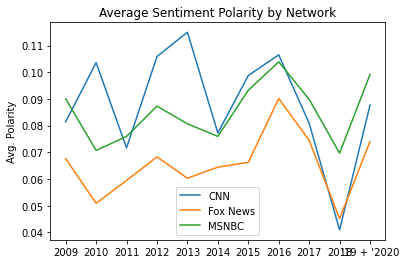

In [56]:
for i, network in enumerate(['CNN', 'Fox News', 'MSNBC']):
    network_avg_polarity_over_time = [get_data_by_channel(get_data_by_year(corpus_df, year), NETWORKS[i])['polarity'].mean() for year in range(2009, 2019)]
    network_avg_polarity_over_time.append(get_data_by_channel(final_years_df, NETWORKS[i])['polarity'].mean())
    plt.plot(years, network_avg_polarity_over_time, label=network)
plt.title("Average Sentiment Polarity by Network")
plt.ylabel("Avg. Polarity")
plt.legend()
plt.show()

In [45]:
cnn_avg_polarity = get_data_by_channel(get_data_by_year(corpus_df, 2009), NETWORKS[0])

In [47]:
cnn_avg_polarity['polarity'].mean()

0.08138480256029533

We begin our sentiment analysis module by breaking up the entire corpus by TV network (i.e. CNN, Fox News, MSNBC). We are interested in understanding the sentiment polarity and subjectivity surrounding climate change discussion based on TV network. We note that there are more snippets for Fox News and MSNBC than CNN, so we use the ratio of the number of positive sentiment snippets / negative sentiment snippets to compare them appropriately. We use a pre-trained Naive Bayes Classifier offered by the TextBlob NLP Python package to classify the snippets across the entire corpus into Positive, Neutral, and Negative classes. We find the respective Positive/Negative ratios to be: CNN: 3.582;  Fox News: 2.416; MSNBC: 3.343. Our main finding from this is that across the networks, Fox News had the lowest positive / negative ratio indicating that as a network, they had relatively the most negative commentary surrounding climate change topics. 

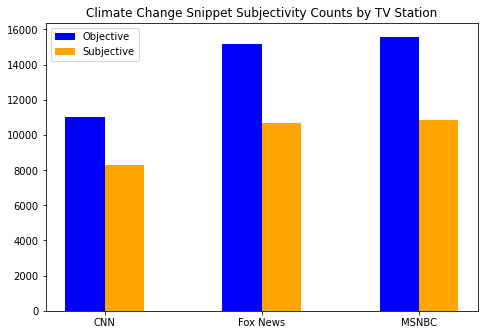

In [14]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, objective_counts, color='blue', width=width, label="Objective")
ax.bar(X + 1*width, subjective_counts, color='orange', width=width, label="Subjective")
ax.set_title("Climate Change Snippet Subjectivity Counts by TV Station")
ax.set_xticks(X + width/2)
ax.set_xticklabels(('CNN', 'Fox News', 'MSNBC'))
ax.legend()
plt.show()

Additionally, we used a pre-trained Naive Bayes subjectivity classifier also provided by TextBlob to classify the snippets as being in objective or subjective classes. We report the Objective / Subjective ratios for each of the networks across the entire corpus: 
CNN: 1.331;  Fox News: 1.418; MSNBC: 1.44. The difference between these ratios isn’t as large as was the case with sentiment, but we notice the ratio of objective snippets / subjective snippets is lower for CNN than it is for Fox News and MSNBC suggesting that CNN has relatively more subjective snippets than the other networks

# TF-IDF Analysis

The TF-IDF statistic provides an effective way to hone in on words that are important for a document (snippets or set of snippets) while also taking into account how prevalent a word is across all the documents in a corpus. We construct our documents at different levels of granularity to uncover the most important words to each document, namely we have looked at the TF-IDF when the documents are the entirety of the snippets for a given network, i.e. one document for CNN snippets, one document for Fox News snippets, and another for MSNBC snippets. After constructing the TF-IDF featurization for our documents, for each document, we select the words which had the top 30 largest TF-IDF scores. At the level of the TV networks, we find that the most interesting finding is that  CNN & MSNBC which are more liberal-leaning networks have a higher TF-IDF score for Trump than FOX does which is conservative-leaning network. Additionally, Fox News has a higher TF-IDF score for Obama than 

In [15]:
# documents_list is a list of strings, where each string is preprocessed document (e.g. preprocessed snippet).
def fit_tfidf_vectorizer(documents_list):
    vectorizer = TfidfVectorizer()
    vectorized_document_array = vectorizer.fit_transform(documents_list).toarray()
    features_array = np.array(vectorizer.get_feature_names())
    return vectorized_document_array, features_array

def get_top_tfidf_words_per_document(n, documents_list):
    vectorized_document_array, features_array = fit_tfidf_vectorizer(documents_list)
    num_docs = vectorized_document_array.shape[0]
    top_words_list = []
    # I.e. the words which had the largest tf-idf scores for document i will be the list located 
    # at index i in top_words_list in descending order of tf-idf score.
    for i in range(num_docs):
        doc_tfidf_vector = vectorized_document_array[i, :]
        top_tfidf_doc_indices = doc_tfidf_vector.argsort()[::-1]
        top_n_tfidf_words_for_doc = features_array[top_tfidf_doc_indices][:n]
        top_n_word_tfidf_scores_for_doc = np.sort(doc_tfidf_vector)[::-1][:n]
        top_n_words_tfidf_list_for_doc = [(word, tfidf) for word, tfidf in zip(top_n_tfidf_words_for_doc,                                                            top_n_word_tfidf_scores_for_doc)]
        top_words_list.append(top_n_words_tfidf_list_for_doc)
    return top_words_list


In [16]:
cnn_document = create_document(cnn_df['Snippet'].to_list())
fox_document = create_document(fox_df['Snippet'].to_list())
msnbc_document = create_document(msnbc_df['Snippet'].to_list())
network_doc_list = [cnn_document, fox_document, msnbc_document]

In [17]:
n = 30
top_n_words_tfidf_by_network = get_top_tfidf_words_per_document(n, network_doc_list)

In [18]:
cnn_top_n_words_tfidf, fox_top_n_words_tfidf, msnbc_top_n_words_tfidf = top_n_words_tfidf_by_network[0], top_n_words_tfidf_by_network[1], top_n_words_tfidf_by_network[2]

In [19]:
cnn_top_n_words_tfidf

[('president', 0.367868207709012),
 ('issue', 0.2122987443902088),
 ('think', 0.2105545058799606),
 ('people', 0.18464010515627316),
 ('trump', 0.17550361772163975),
 ('world', 0.15058592471809412),
 ('know', 0.14950615802127382),
 ('right', 0.13621672175271612),
 ('year', 0.13497083710253885),
 ('new', 0.13447248324246794),
 ('state', 0.1123787954459908),
 ('country', 0.11021926205235019),
 ('time', 0.10697996196188926),
 ('he', 0.10689690298521078),
 ('gas', 0.10581713628839046),
 ('believe', 0.09560088215693675),
 ('scientist', 0.09526864625022281),
 ('greenhouse', 0.09202934615976188),
 ('thing', 0.09036816662619217),
 ('reporter', 0.08837475118590851),
 ('obama', 0.08820863323255154),
 ('crisis', 0.08687968960569578),
 ('deal', 0.08604909983891092),
 ('need', 0.08364038951523485),
 ('emission', 0.08114862021488028),
 ('question', 0.07857379193784723),
 ('united', 0.07741096626434844),
 ('real', 0.07691261240427752),
 ('today', 0.07541755082406479),
 ('big', 0.07392248924385204)]

In [20]:
fox_top_n_words_tfidf

[('president', 0.2775629820423726),
 ('people', 0.25455825536101173),
 ('think', 0.2522988625619495),
 ('know', 0.17294624880094556),
 ('issue', 0.16130695256335223),
 ('new', 0.1568566334136842),
 ('right', 0.15233784781555973),
 ('year', 0.15090005239797466),
 ('world', 0.12947005403111164),
 ('gas', 0.12173334535553491),
 ('time', 0.1168722275151283),
 ('obama', 0.10899858594263868),
 ('bill', 0.10845085435498723),
 ('believe', 0.10235734044236484),
 ('state', 0.10174114240625697),
 ('country', 0.09852321932880469),
 ('greenhouse', 0.09777008839578395),
 ('say', 0.08921178233873003),
 ('trump', 0.08873251719953501),
 ('thing', 0.08811631916342713),
 ('deal', 0.08606232570973418),
 ('american', 0.0856515270189956),
 ('threat', 0.08537766122516988),
 ('democrat', 0.08202280525080474),
 ('tax', 0.08154354011160972),
 ('need', 0.07791481834341886),
 ('problem', 0.07606622423509521),
 ('big', 0.07503922750824875),
 ('emission', 0.07353296564220725),
 ('carbon', 0.0731906333999251)]

In [21]:
msnbc_top_n_words_tfidf

[('president', 0.27975289549423926),
 ('think', 0.2508213953467193),
 ('people', 0.2191928909481594),
 ('issue', 0.21569904453203942),
 ('know', 0.16776592352491954),
 ('right', 0.15703920207191957),
 ('republican', 0.14159272317959962),
 ('new', 0.13515669030779964),
 ('year', 0.13184673054515963),
 ('country', 0.12412349109899966),
 ('state', 0.12118130464331967),
 ('trump', 0.11946502921083968),
 ('time', 0.11830041373879968),
 ('believe', 0.1122321541739597),
 ('world', 0.1121708586227997),
 ('he', 0.10316041260227972),
 ('gas', 0.10150543272095973),
 ('thing', 0.09372089772363974),
 ('need', 0.08924632248895975),
 ('science', 0.08912373138663976),
 ('today', 0.08569118052167976),
 ('there', 0.08562988497051977),
 ('energy', 0.08458786060079977),
 ('greenhouse', 0.08397490508919978),
 ('real', 0.08366842733339977),
 ('big', 0.08207474300323978),
 ('obama', 0.07925514764987979),
 ('american', 0.0749031635175198),
 ('care', 0.0747192768640398),
 ('problem', 0.0718996815106798)]

We now do a similar process of applying TF-IDF featurization by year (11 documents), this will uncover what words were important to each year. For 2009-2018, we construct a document for each year the same way, by filtering the DF by year, except 2019-2020, since 2020 only has January data, so we combine 2019 + 2020 as a single document


In [22]:
first_10_years_documents = [create_document(get_data_by_year(corpus_df, year)['Snippet'].tolist()) for year in range(2009, 2019)]
final_years_document = create_document(final_years_df['Snippet'].tolist())
all_years_documents = first_10_years_documents + [final_years_document]

In [24]:
n = 30
top_n_words_tfidf_by_year = get_top_tfidf_words_per_document(n, all_years_documents)

In [25]:
for year_i, top_n_words_year_i in zip(years, top_n_words_tfidf_by_year):
    print('In the year {}, we find the top {} words with highest tf-idf scores are: \n'.format(year_i, n))
    print(list(map(lambda x: x[0], top_n_words_year_i)))
    print('\n')

In the year 2009, we find the top 30 words with highest tf-idf scores are: 

['president', 'copenhagen', 'gas', 'greenhouse', 'think', 'people', 'world', 'obama', 'bill', 'emission', 'year', 'right', 'know', 'issue', 'email', 'new', 'country', 'time', 'scientist', 'health', 'summit', 'energy', 'debate', 'next', 'care', 'nation', 'conference', 'state', 'today', 'believe']


In the year 2010, we find the top 30 words with highest tf-idf scores are: 

['people', 'think', 'bill', 'know', 'fiftyton', 'energy', 'right', 'president', 'year', 'country', 'new', 'lightest', 'gas', 'time', 'republican', 'legislation', 'issue', 'greenhouse', 'america', 'tallest', 'tax', 'environment', 'gore', 'big', 'al', 'facing', 'nation', 'house', 'barely', 'question']


In the year 2011, we find the top 30 words with highest tf-idf scores are: 

['think', 'know', 'believe', 'right', 'people', 'republican', 'gas', 'issue', 'greenhouse', 'gingrich', 'president', 'year', 'he', 'romney', 'newt', 'new', 'perry', 's

After finding the top 30 words by tf-idf score per year, we see some topical events emerge by year. We discuss this by year when using the top 30 tf-idf scores and assciated words in each year:

### 2009
In 2009, we see Copenhagen, Obama, 


We now do the final TF-IDF calculation. We look at the documents created both by year and by network. This yields ~33 documents and allows to see who was saying what and in what year they were saying it.

In [ ]:
first_10_years_documents = [create_document(get_data_by_year(corpus_df, year)['Snippet'].tolist()) for year in range(2009, 2019)]
_2019_data = get_data_by_year(corpus_df, 2019)
_2020_data = get_data_by_year(corpus_df, 2020)
final_years_df = pd.concat([_2019_data, _2020_data])
final_years_document = create_document(final_years_df['Snippet'].tolist())

In [34]:
years_with_network_documents = []
for year in range(2009, 2019):
    for network in NETWORKS:
        df_for_year_and_network = get_data_by_channel(get_data_by_year(corpus_df, year), network)
        snippets_list = df_for_year_and_network['Snippet'].tolist()
        years_with_network_documents.append(create_document(snippets_list))

In [35]:
for network in NETWORKS:
    final_year_with_network_df = get_data_by_channel(final_years_df, network)
    snippets_list = final_year_with_network_df['Snippet'].tolist()
    years_with_network_documents.append(create_document(snippets_list))

In [36]:
top_n_words_tfidf_by_year_and_network = get_top_tfidf_words_per_document(n, years_with_network_documents)

In [43]:
for i, year in zip(range(0, 33, 3), years):
    print('In the year {}, we find the top {} words with highest tf-idf scores for each network are:'.format(year, n))
    print('\n')
    for j, network in enumerate(NETWORKS):
        tf_idf_idx = i + j
        word_list = top_n_words_tfidf_by_year_and_network[tf_idf_idx]
        print('For {}:'.format(network))
        print(list(map(lambda x: x[0], word_list)))
        print('\n')

In the year 2009, we find the top 30 words with highest tf-idf scores for each network are:


For CNN:
['copenhagen', 'president', 'gas', 'greenhouse', 'world', 'email', 'people', 'emission', 'scientist', 'summit', 'obama', 'right', 'issue', 'debate', 'year', 'think', 'time', 'reporter', 'today', 'country', 'new', 'leader', 'health', 'nation', 'know', 'science', 'deal', 'conference', 'question', 'hacked']


For FOXNEWS:
['president', 'bill', 'copenhagen', 'gas', 'greenhouse', 'think', 'obama', 'people', 'world', 'year', 'emission', 'shredded', 'know', 'right', 'country', 'house', 'email', 'new', 'conference', 'scientist', 'bret', 'issue', 'time', 'next', 'wheat', 'american', 'state', 'united', 'big', 'sean']


For MSNBC:
['president', 'copenhagen', 'think', 'people', 'palin', 'energy', 'health', 'care', 'know', 'obama', 'gas', 'world', 'new', 'issue', 'emission', 'right', 'gore', 'year', 'greenhouse', 'time', 'al', 'today', 'country', 'sarah', 'legislation', 'next', 'bill', 'believe', 